In [1]:

import numpy as np
import jijmodeling as jm
import openjij as oj
import ommx_openjij_adapter as oj_ad

N      = jm.Placeholder("N")                    # total cells
Nk     = jm.Placeholder("Nk", ndim=1)           # [burnt, fresh]
edges  = jm.Placeholder("edges", ndim=2)        # |E|×2 adjacency

k = jm.Element("k", (0, 2))                     # 0 … 1
i = jm.Element("i", (0, N))                     # 0 … N-1
e = jm.Element("e", (0, edges.shape[0]))        # 0 … |E|-1

x = jm.BinaryVar("x", shape=(2, N))             # decision vars

problem = jm.Problem("core-layout")

# objective – penalise identical neighbours
problem += jm.sum([k, e], x[k, edges[e, 0]] * x[k, edges[e, 1]])

# one assembly per cell
problem += jm.Constraint("single-assembly",
                         jm.sum(k, x[k, i]) == 1,
                         forall=i)

# exact inventory
problem += jm.Constraint("inventory",
                         jm.sum(i, x[k, i]) == Nk[k],
                         forall=k)
problem

In [2]:

# ----------------------------------------------------------------------
# 2. CONCRETE DATA  -----------------------------------------------------
# ----------------------------------------------------------------------
import time
edges_1 = [
    (1,2),(1,5),(2,3),(2,6),(3,7),(4,5),(4,10),(5,6),(5,11),(6,7),
    (6,12),(7,8),(7,13),(8,14),(9,10),(9,16),(10,11),(10,17),(11,12),(11,18),
    (12,13),(12,19),(13,14),(13,20),(14,15),(14,21),(15,22),(16,17),(16,23),(17,18),
    (17,24),(18,19),(18,25),(19,20),(19,26),(20,21),(20,27),(21,22),(21,28),(22,29),
    (23,24),(24,25),(24,30),(25,26),(25,31),(26,27),(26,32),(27,28),(27,33),(28,29),
    (28,34),(30,31),(31,32),(31,35),(32,33),(32,36),(33,34),(33,37),(35,36),(36,37)
]
edges0 = np.array(edges_1) - 1                 # 0-indexed
N_cells = 37
burnt, fresh = 16, 21                         # inventory sums to 37

instance_data = {
    "N":     N_cells,
    "Nk":    np.array([burnt, fresh]),
    "edges": edges0
}

# ----------------------------------------------------------------------
# 3. OMMX INSTANCE  -----------------------------------------------------
# ----------------------------------------------------------------------
instance = jm.Interpreter(instance_data).eval_problem(problem)

# ----------------------------------------------------------------------
# 4. CONSTRAINTS → QUBO  ------------------------------------------------
# ----------------------------------------------------------------------
qubo, offset = instance.to_qubo(
    uniform_penalty_weight            = 5,
    inequality_integer_slack_max_range = 64   # generous ceiling
)

# ----------------------------------------------------------------------
# 5. OPENJIJ SAMPLING  --------------------------------------------------
# ----------------------------------------------------------------------
t2 = time.perf_counter()           
sampler   = oj.SASampler()
response  = sampler.sample_qubo(qubo, num_reads=10_000)

# shift energies back
response.record.energy += offset
t3 = time.perf_counter()  
print(f"OpenJij best raw energy : {response.first.energy:.2f}")

# ----------------------------------------------------------------------
# 6. DECODE AND DISPLAY  ------------------------------------------------
# ----------------------------------------------------------------------
# -------------------------------------------------------------
# 6.  DECODE RAW BITS → ORIGINAL VARIABLES
# -------------------------------------------------------------
adapter   = oj_ad.OMMXOpenJijSAAdapter(instance)
sampleset = adapter.decode_to_sampleset(response)

best   = sampleset.best_feasible_unrelaxed      # property (no parentheses)
layout = best.extract_decision_variables("x")   # shape (2, 37) # shape (2, 37)

#print("Shifted objective energy :", best.energy)
print("\nDecoded layout (cell : fuel)")
for idx in range(N_cells):
    fuel = "burnt" if layout[0, idx] else "fresh"
    print(f"  {idx:2d} : {fuel}")

print(f"anneal (10k reads) : {t3-t2:7.3f}  s")


OpenJij best raw energy : 0.00

Decoded layout (cell : fuel)
   0 : fresh
   1 : burnt
   2 : fresh
   3 : fresh
   4 : burnt
   5 : fresh
   6 : burnt
   7 : fresh
   8 : fresh
   9 : burnt
  10 : fresh
  11 : burnt
  12 : fresh
  13 : burnt
  14 : fresh
  15 : burnt
  16 : fresh
  17 : burnt
  18 : fresh
  19 : burnt
  20 : fresh
  21 : burnt
  22 : fresh
  23 : burnt
  24 : fresh
  25 : burnt
  26 : fresh
  27 : burnt
  28 : fresh
  29 : fresh
  30 : burnt
  31 : fresh
  32 : burnt
  33 : fresh
  34 : fresh
  35 : burnt
  36 : fresh
anneal (10k reads) :  15.613  s


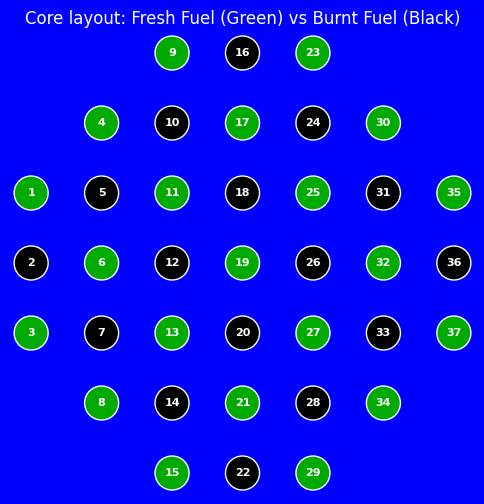

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# --- mapping rows (diagram shape) ---
row_cells = [
    [9, 16, 23],
    [4, 10, 17, 24, 30],
    [1, 5, 11, 18, 25, 31, 35],
    [2, 6, 12, 19, 26, 32, 36],
    [3, 7, 13, 20, 27, 33, 37],
    [8, 14, 21, 28, 34],
    [15, 22, 29]
]

# create dummy layout if it doesn't exist
try:
    layout
except NameError:
    layout = np.zeros((2, 37), dtype=int)
    for n in range(37):
        if (n+1) % 2 == 0:
            layout[0, n] = 1  # burnt
        else:
            layout[1, n] = 1  # fresh

# gather scatter data
xs, ys, colors, labels = [], [], [], []
for y, row in enumerate(row_cells):
    x_offset = (max(len(r) for r in row_cells) - len(row)) / 2
    for x_in_row, cell_num in enumerate(row):
        xs.append(x_offset + x_in_row)
        ys.append(-y)
        if layout[0, cell_num - 1]:
            colors.append("#000000")   # Burnt → black
        else:
            colors.append("#00AA00")   # Fresh → green
        labels.append(str(cell_num))

# plot with updated background and colors
fig, ax = plt.subplots(figsize=(6, 6))
fig.patch.set_facecolor('blue')      # background outside plot
ax.set_facecolor('blue')             # background inside plot

scatter = ax.scatter(xs, ys, c=colors, s=600, edgecolors='white')  # edgecolor optional
for xpt, ypt, lab in zip(xs, ys, labels):
    ax.text(xpt, ypt, lab, ha='center', va='center', color='white', fontsize=8, fontweight='bold')

ax.axis('off')
ax.set_title("Core layout: Fresh Fuel (Green) vs Burnt Fuel (Black)", color='white')
plt.show()
